In [3]:
!pip install -q catalyst

In [4]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.zeros(out_features, requires_grad=True))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [20]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

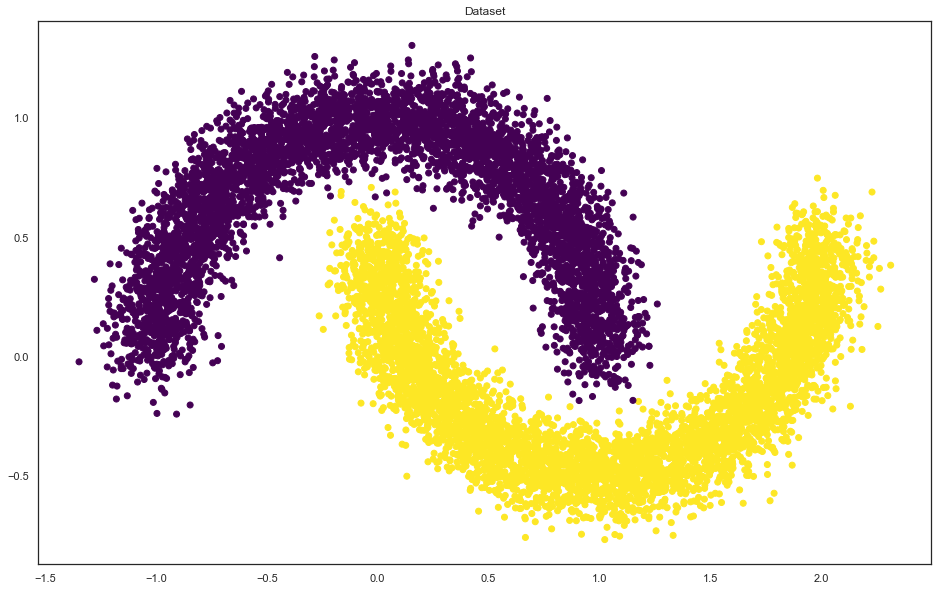

In [21]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [23]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.from_numpy(y_train.astype(np.float32))
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =  torch.from_numpy(y_val.astype(np.float32))

In [24]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [25]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [26]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
count_parameters(linear_regression)

3

In [28]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6484375
Iteration: 7500
Batch accuracy: 0.734375
Iteration: 15000
Batch accuracy: 0.78125
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8046875
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90051.Convergence. Stopping iterations.


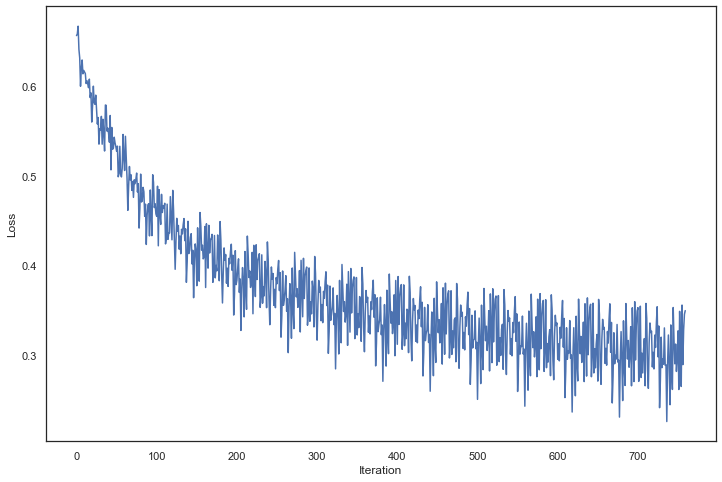

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

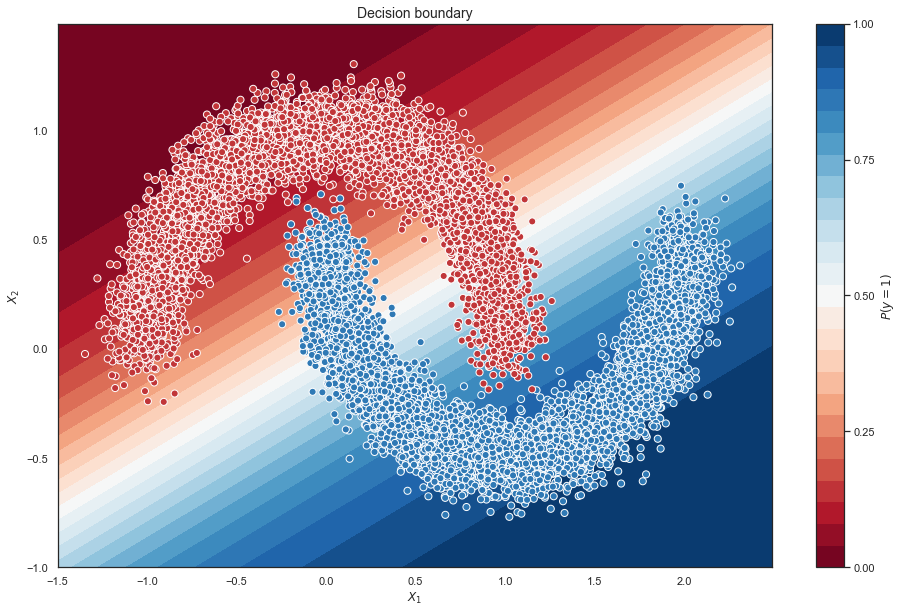

In [30]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [31]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.862

In [33]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
train_dataloader = DataLoader(train_dataset, batch_size=4)
valid_dataloader = DataLoader(val_dataset, batch_size=4)

0it [00:00, ?it/s]

 97%|█████████▋| 9568256/9912422 [00:02<00:00, 11586256.30it/s]

Extracting c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw\train-images-idx3-ubyte.gz to c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw


Extracting c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw\train-labels-idx1-ubyte.gz to c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw


Extracting c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw\t10k-images-idx3-ubyte.gz to c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw




C:\ProgramData\Anaconda3\lib\site-packages\catalyst\contrib\datasets\functional.py:188: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
9920512it [00:05, 1795065.49it/s]                              
32768it [00:02, 12372.21it/s]            
1654784it [00:01, 865691.21it/s]                             
8192it [00:00, 14051.49it/s]            


Extracting c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw\t10k-labels-idx1-ubyte.gz to c:\Users\User\Documents\PROJECTS\python\deep_learning_mfti\Домашнее задание. Сверточные и полносвязные нейросети\MNIST\raw
Processing...
Done!


In [34]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [51]:
activation = Identical

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(torch.float32))
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch.to(torch.float32))
            preds = outp.argmax(-1)
            correct =  (0 == abs(preds - y_batch)).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7928
Loader: valid. Accuracy: 0.7967571428571428
Epoch: 2
Loader: train. Accuracy: 0.8329166666666666
Loader: valid. Accuracy: 0.8165571428571429
Epoch: 3
Loader: train. Accuracy: 0.8399
Loader: valid. Accuracy: 0.8366714285714286
Epoch: 4
Loader: train. Accuracy: 0.8442666666666667
Loader: valid. Accuracy: 0.8338857142857143
Epoch: 5
Loader: train. Accuracy: 0.8484333333333334
Loader: valid. Accuracy: 0.8341285714285714
Epoch: 6
Loader: train. Accuracy: 0.8478833333333333
Loader: valid. Accuracy: 0.8469714285714286
Epoch: 7
Loader: train. Accuracy: 0.8522666666666666
Loader: valid. Accuracy: 0.8494
Epoch: 8
Loader: train. Accuracy: 0.8534833333333334
Loader: valid. Accuracy: 0.8410857142857143
Epoch: 9
Loader: train. Accuracy: 0.85535
Loader: valid. Accuracy: 0.8526857142857143
Epoch: 10
Loader: train. Accuracy: 0.8556666666666667
Loader: valid. Accuracy: 0.8461857142857143


In [40]:
elu_accuracy = accuracy["valid"]

In [45]:
relu_accuracy = accuracy["valid"]

In [50]:
leaky_relu_accuracy = accuracy["valid"]

In [55]:
plain_accuracy = accuracy["valid"]

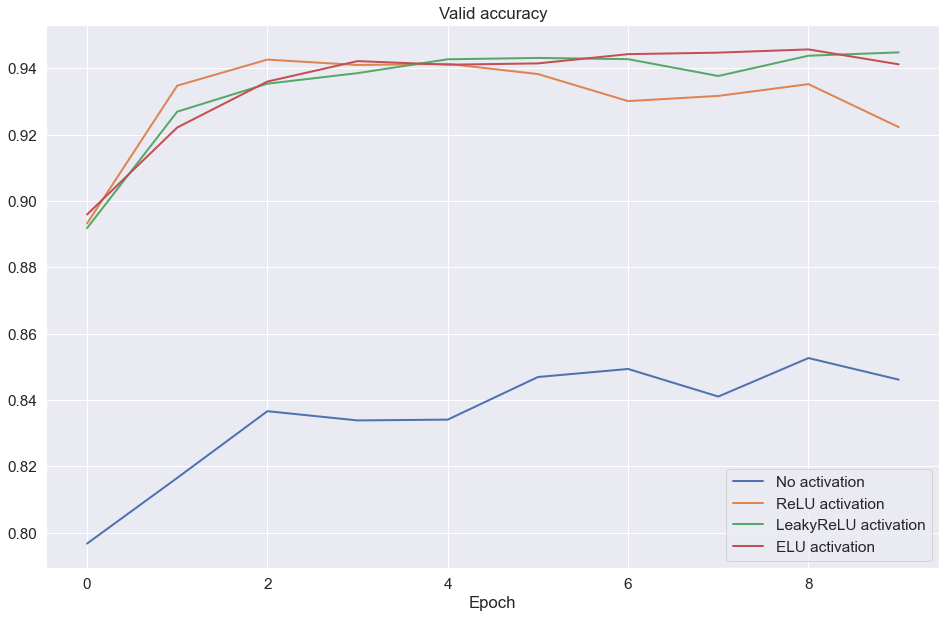

In [56]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

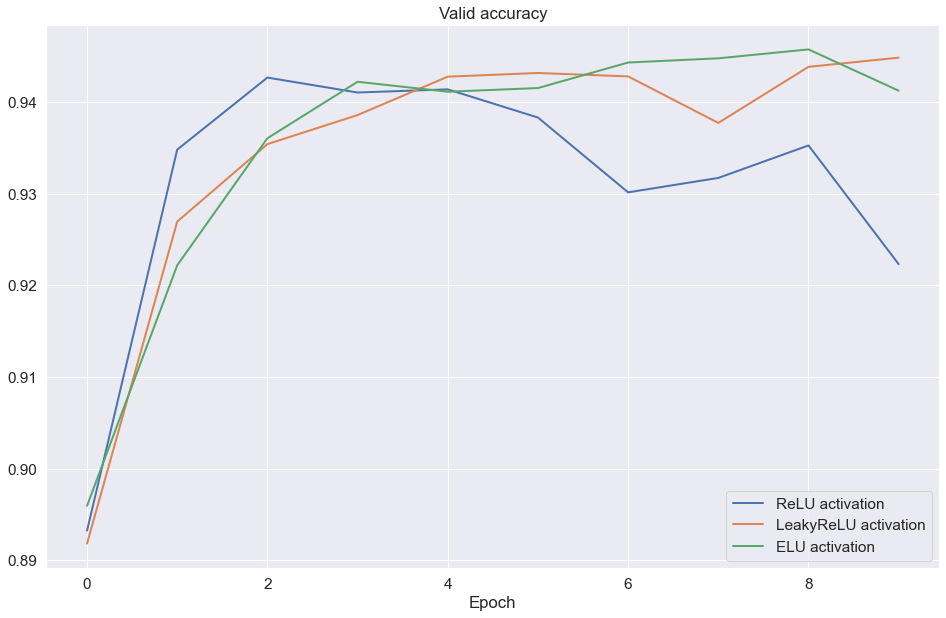

In [57]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

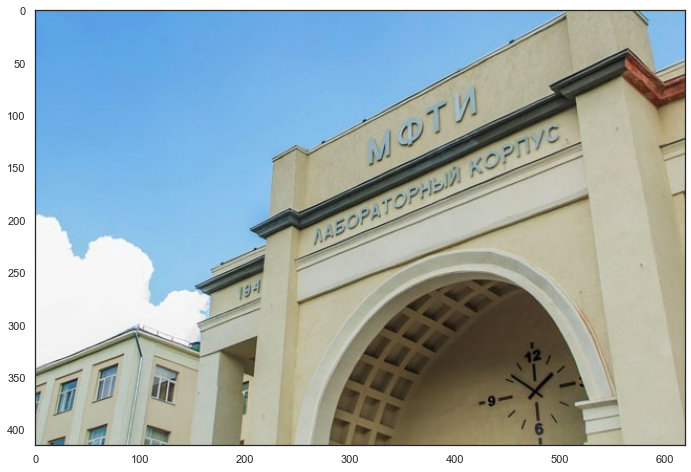

In [59]:
#!pip install opencv-python
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [71]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

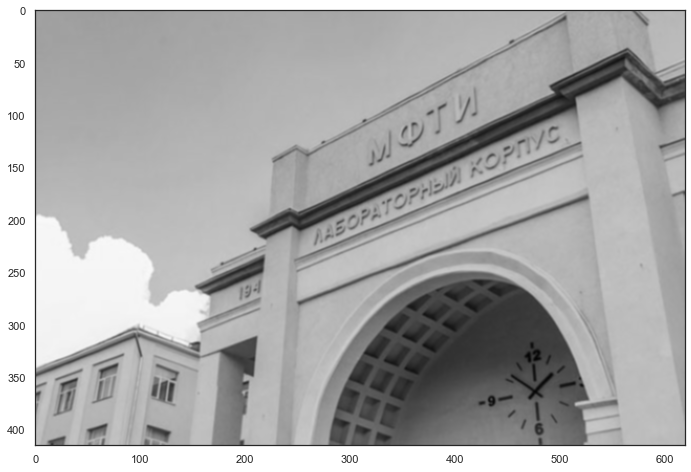

In [72]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [73]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [74]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [77]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch[:, np.newaxis].to(torch.float32))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch[:, np.newaxis].type(torch.float32))
            preds = outp.argmax(-1)
            correct =  (0 == abs(preds - y_batch)).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9755666666666667
Loader: valid. Accuracy: 0.9747
Epoch: 2
Loader: train. Accuracy: 0.9792166666666666
Loader: valid. Accuracy: 0.9785142857142857
Epoch: 3
Loader: train. Accuracy: 0.9800833333333333
Loader: valid. Accuracy: 0.9787571428571429
Epoch: 4
Loader: train. Accuracy: 0.9809333333333333
Loader: valid. Accuracy: 0.9809857142857142
Epoch: 5
Loader: train. Accuracy: 0.9820333333333333
Loader: valid. Accuracy: 0.9807
Epoch: 6
Loader: train. Accuracy: 0.9820833333333333
Loader: valid. Accuracy: 0.9805714285714285
Epoch: 7
Loader: train. Accuracy: 0.98305
Loader: valid. Accuracy: 0.9820857142857143
Epoch: 8
Loader: train. Accuracy: 0.98355
Loader: valid. Accuracy: 0.9800571428571428
Epoch: 9
Loader: train. Accuracy: 0.98315
Loader: valid. Accuracy: 0.9823428571428572
Epoch: 10
Loader: train. Accuracy: 0.9842666666666666
Loader: valid. Accuracy: 0.9824857142857143


In [78]:
lenet_accuracy = accuracy["valid"]

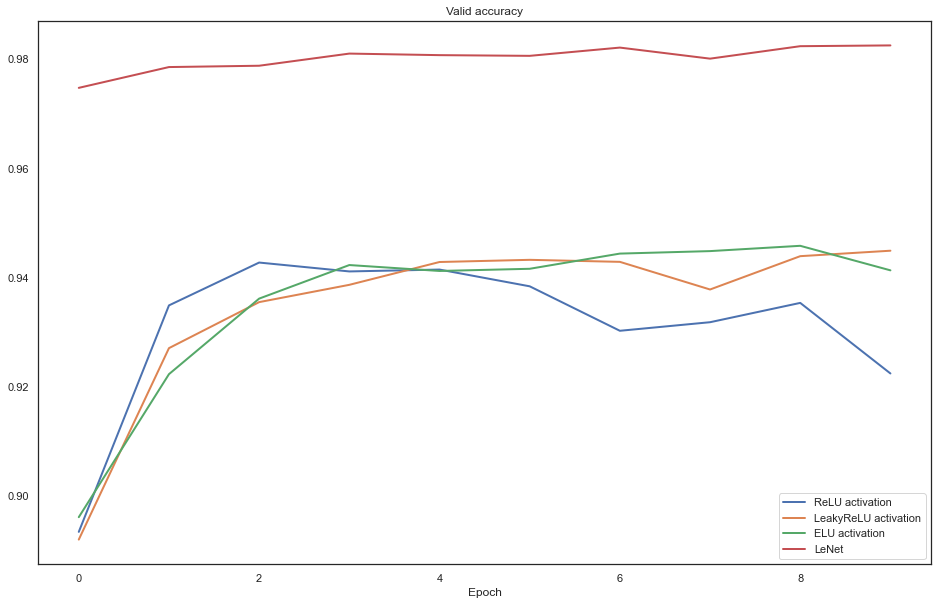

In [79]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [80]:
lenet_accuracy[-1]

0.9824857142857143